# Реализация предсказателя на основе LSTM 

## 1. Импорт библиотек и чтение датасета

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

C:\Users\Nikita\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
C:\Users\Nikita\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Читаем даныне для обучения
data = pd.read_csv('./eeg_one.csv')

In [3]:
# Преобразуем даныне, имеют два столбца
data = data['0']

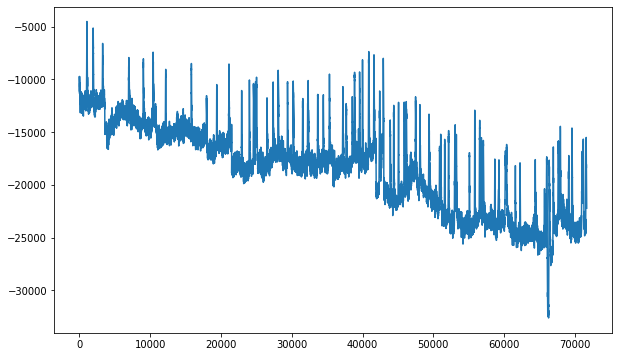

In [4]:
# Отображаем данные полученные из файла
plt.figure(figsize=(10,6))
plt.plot(data)
plt.show()

## 2. Нормализация данных

Можно видеть, что данные имеют слишком боьльшой разброс, по этой причине необходимо произвести их нормализаци.

In [5]:
# Функция нормализации
# Получаем среднее значение данных, вычитаем его из значения и делим на стандартное отклонения
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

In [6]:
data = normalize(data)

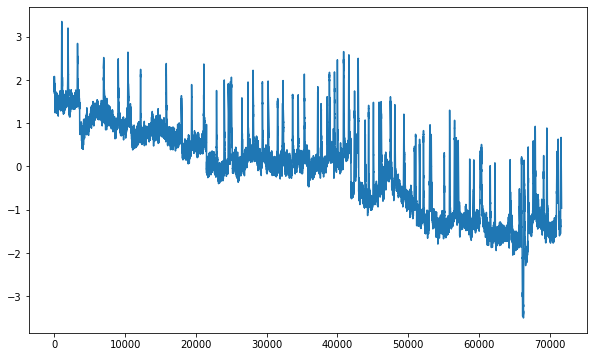

In [7]:
# Отображаем нормированные данные
plt.figure(figsize=(10,6))
plt.plot(data)
plt.show()

## Отступление
    При классическом обучении нейронных сетей, датасет разбивается на тренировочную, валидационную и тестовую выборки. В данно случае, сеть пытается предсказывать данные в реальном времени на один шаг в перед с дополнительным обучением. Таким образом, нам не нужно разделение на три датасета, а только необходимо взять один датасет и подготовить его правильно с окном смещения.

## 3. Подготовка датасета

В связи с тем, что LSTM модель требует специфической формы подачи даных, была написана функция create_dataset представленная ниже. Данная функция позволяет достичь формы представленной на рисунке № 1.
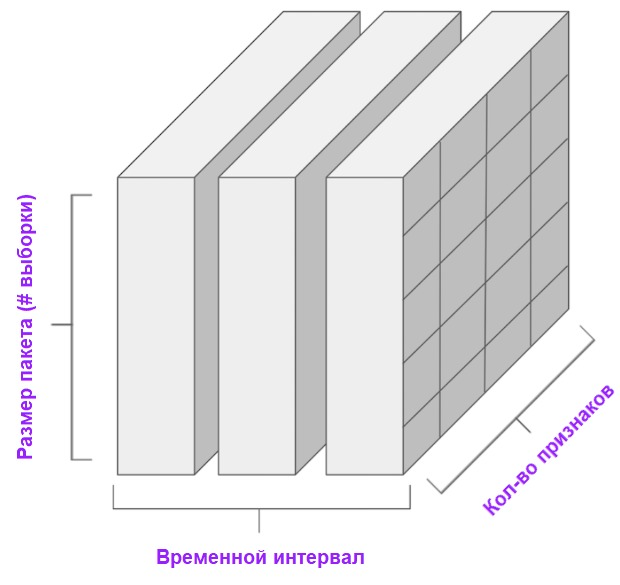

In [8]:
# Переменная с каким окном выборки будет работать система
time_step = 10

In [9]:
def create_dataset(data, time_step = 1):
    len_arr = int(len(data) / time_step)
    X, y = [], []
    for i in range(len_arr):
        X.append(data[i:(i+time_step)])
        y.append(data[i + time_step])
    X = np.array(X)
    y = np.array(y)
    return X, y
#     return X.reshape((X_train.shape[0], time_step, 1)), y.reshape((y.shape[0], 1))
#     return np.array(X).reshape((X_train.shape[0], time_step, 1)), np.array(y).reshape((y.shape[0], 1))

In [10]:
X_train, y_train = create_dataset(data, time_step)
print(f'Размер выборки обучения: {X_train.shape}')
print(f'Размер выборки предсказания: {y_train.shape}')

Размер выборки обучения: (7168, 10)
Размер выборки предсказания: (7168,)


## 4. Создание нейронной сети 

In [11]:
# Создание модели LSTM
model = Sequential()
model.add(tf.keras.layers.Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(time_step, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(10, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 10)            480       
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dense (Dense)               (None, 25)                275       
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1,621
Trainable params: 1,621
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Компиляция модели
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
# model.compile(optimizer=opt, loss='mean_squared_error')
model.compile(optimizer=opt, loss='mean_absolute_error')

## 5. Обучение нейронной сети 

In [13]:
predict_data = []
data_real = []
for i in range(X_train.shape[0] - 1):
    model.fit(X_train[i].reshape((1,time_step,1)),
              y_train[i].reshape((1,1)),
              epochs = 10,
              batch_size=1)
#     data_real.append(data[i+time_step])
    data_real.append(y_train[i+1])
    out = model.predict(X_train[i+1].reshape((1,time_step,1)))
    predict_data.append(out.sum() / len(out))
    
plt.figure(figsize=(10,6))
plt.plot(data_real)
plt.plot(predict_data)
len(data_real)

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 2.3280
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 1.9619
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 1.6787
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 1.3968
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 1.0637
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6530
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.1473
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.4631
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6998
Epoch 10/10
1/1 [==============================] - 0s 410ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.5642
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.3330
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0673
Epoch 4/10
1

1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0296
Epoch 2/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0165
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0203
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0286
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0115
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0290
Epoch 7/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0402
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0247
Epoch 9/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0144
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0196
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0193
Epoch 3/10
1/1 [===============

1/1 [==============================] - 0s 5ms/step - loss: 0.0193
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0344
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0313
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0467
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0669
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0612
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0321
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0189
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0402
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0073
Epoch 2/10
1/1 [====================

1/1 [==============================] - 0s 5ms/step - loss: 0.1300
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.1241
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0232
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0398
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0747
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0831
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0675
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0308
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0237
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0507
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0538
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [====================

1/1 [==============================] - 0s 8ms/step - loss: 0.0036
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0188
Epoch 9/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0115
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0216
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0338
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0464
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0372
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0083
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0393
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0608
Epoch 9/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0584
Epoch 10/10
1/1 [======

1/1 [==============================] - 0s 5ms/step - loss: 0.0172
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0178
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 8.3578e-04
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0324
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0329
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0082
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0316
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0497
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0488
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0307
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0159
Epoch 9/10
1/1 [===

1/1 [==============================] - 0s 6ms/step - loss: 0.0260
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0278
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0602
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0742
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0719
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0683
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0252
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0302
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0644
Epoch 5/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0785
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0743
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0536
Epoch 8/10
1/1 [=======

1/1 [==============================] - 0s 7ms/step - loss: 0.0624
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0587
Epoch 6/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0398
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0076
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0358
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0599
Epoch 10/10
1/1 [==============================] - 0s 16ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.1233
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 0.1020
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0680
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0220
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0356
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0723
Epoch 7/10
1/1 [====

1/1 [==============================] - 0s 9ms/step - loss: 0.0199
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0392
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0407
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0264
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0025
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0125
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0052
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 5.8758e-04
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0114
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0062
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0143
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0169
Epoch 6/10
1/1 [===

1/1 [==============================] - 0s 9ms/step - loss: 0.0265
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0437
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0447
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0312
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0042
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0352
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0558
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0589
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0545
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0158
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0330
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0622
Epoch 5/10
1/1 [=====

1/1 [==============================] - 0s 9ms/step - loss: 0.0215
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0139
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0047
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0096
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0163
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0212
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0140
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0042
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0118
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0069
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0120
Epoch 4/10
1/1 [=====

1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0188
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0075
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0014
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0156
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0194
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0113
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0077
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0130
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0346
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0391
Epoch 3/10
1/1 [====================

1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 19ms/step - loss: 0.0723
Epoch 2/10
1/1 [==============================] - 0s 16ms/step - loss: 0.0607
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0369
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0439
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0715
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0820
Epoch 8/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0769
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0579
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0819
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0319
Epoch 3/10
1/1 [=================

1/1 [==============================] - 0s 9ms/step - loss: 0.0062
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0753
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0658
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0434
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0100
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0329
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0581
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0681
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0645
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0486
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0655
Epoch 2/10
1/1 [===================

1/1 [==============================] - 0s 12ms/step - loss: 0.0522
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0321
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0219
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0283
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0600
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0759
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0778
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0671
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0451
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0123
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0305
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==================

1/1 [==============================] - 0s 9ms/step - loss: 0.0395
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0298
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0087
Epoch 10/10
1/1 [==============================] - 0s 18ms/step
Epoch 1/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0321
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0343
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0245
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0035
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0278
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0437
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0454
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0345
Epoch 9/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0122
Epoch 10/10
1/1 [==

1/1 [==============================] - 0s 10ms/step - loss: 0.0215
Epoch 6/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0155
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 2.6584e-04
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0041
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0028
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0792
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0749
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0606
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0371
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0049
Epoch 6/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0355
Epoch 7/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0610
Epoch 8/1

1/1 [==============================] - 0s 9ms/step - loss: 0.0269
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0122
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0348
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0430
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0385
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0225
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0043
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0097
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0099
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0022
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 7.0429e-04
Epoch 6/10
1/1 [==

1/1 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0147
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0188
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0118
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0052
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0098
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0031
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0137
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0104
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0063
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0106
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0037
Epoch 5/10
1/1 [====

1/1 [==============================] - 0s 10ms/step - loss: 0.0658
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0383
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0021
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0424
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0712
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0854
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0860
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0745
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0522
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0767
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.1007
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.1111
Epoch 4/10
1/1 [======

1/1 [==============================] - 0s 16ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0267
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0080
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0184
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0323
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0354
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0288
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0134
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0100
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0216
Epoch 10/10
1/1 [==============================] - 0s 16ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0428
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0250
Epoch 3/10
1/1 [=====================

1/1 [==============================] - 0s 11ms/step - loss: 0.0441
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0159
Epoch 2/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0214
Epoch 3/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0445
Epoch 4/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0554
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0554
Epoch 6/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0457
Epoch 7/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0271
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 1.0037e-04
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0347
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.1526
Epoch 2/10
1/1 [========

1/1 [==============================] - 0s 9ms/step - loss: 0.0331
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0156
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0111
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0142
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0077
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0072
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0115
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0065
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0071
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0103
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0040
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [=================

1/1 [==============================] - 0s 9ms/step - loss: 0.0139
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0209
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0177
Epoch 10/10
1/1 [==============================] - 0s 19ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0540
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0630
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0619
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0519
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0336
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0077
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0255
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0459
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0544
Epoch 10/10
1/1 [===

1/1 [==============================] - 0s 9ms/step - loss: 0.0010
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0084
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0078
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0716
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0711
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0617
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0441
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0188
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0137
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0335
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0416
Epoch 9/10
1/1 [=======

1/1 [==============================] - 0s 14ms/step - loss: 0.0066
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0117
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0145
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0075
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0330
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0195
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0117
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0117
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0027
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0145
Epoch 8/10
1/1 [======

1/1 [==============================] - 0s 10ms/step - loss: 0.1345
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 0.1139
Epoch 6/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0866
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0528
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0119
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0370
Epoch 10/10
1/1 [==============================] - 0s 20ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0440
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0447
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0313
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0050
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0337
Epoch 6/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0529
Epoch 7/10
1/1

1/1 [==============================] - 0s 8ms/step - loss: 1.7142e-04
Epoch 3/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 6/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 8.0121e-04
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0052
Epoch 9/10
1/1 [==============================] - 0s 7ms/step - loss: 3.3689e-04
Epoch 10/10
1/1 [==============================] - 0s 21ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0181
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0107
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0059
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0108
Epoch 5/10

1/1 [==============================] - 0s 7ms/step - loss: 0.0291
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0234
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0098
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0105
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0205
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0214
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0142
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 5.5265e-04
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0056
Epoch 10/10
1/1 [==============================] - 0s 17ms/step
Epoch 1/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0375
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0397
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0335
Epoch 4/10
1/1 [===

1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0265
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0127
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0248
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0273
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0213
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0075
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0136
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0240
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 3/10
1/1 [=====================

1/1 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 10/10
1/1 [==============================] - 0s 20ms/step
Epoch 1/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0022
Epoch 2/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0202
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0310
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0312
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0219
Epoch 6/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0042
Epoch 7/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0209
Epoch 8/10
1/1 [==============================] - 0s 27ms/step - loss: 0.0342
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0371
Epoch 10/10
1/1 [==============================] - 0s 19ms/step
Epoch 1/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0499
Epoch 2/10
1/1 [==========

1/1 [==============================] - 0s 14ms/step - loss: 0.0255
Epoch 8/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0132
Epoch 9/10
1/1 [==============================] - 0s 15ms/step - loss: 0.0060
Epoch 10/10
1/1 [==============================] - 0s 18ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0405
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0323
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0167
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0053
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0170
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0196
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0141
Epoch 8/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0013
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0184
Epoch 10/10
1/1 

1/1 [==============================] - 0s 9ms/step - loss: 0.0156
Epoch 6/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0043
Epoch 7/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0137
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0220
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0216
Epoch 10/10
1/1 [==============================] - 0s 20ms/step
Epoch 1/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0054
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0167
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0285
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0308
Epoch 5/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0247
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0109
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0095
Epoch 8/10
1/1 [===

1/1 [==============================] - 0s 10ms/step - loss: 0.0119
Epoch 4/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0018
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0147
Epoch 6/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0221
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0215
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0136
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 8.6236e-04
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0065
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0111
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0147
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0102
Epoch 6/10
1/

1/1 [==============================] - 0s 11ms/step - loss: 0.1666
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.1629
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.1516
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.1338
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.1103
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0820
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0497
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0140
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0626
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0803
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0896
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0914
Epoch 5/10
1/1 [======

1/1 [==============================] - 0s 9ms/step - loss: 0.0214
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0073
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0131
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0232
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0243
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0173
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0029
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0182
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0292
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0708
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0565
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0356
Epoch 4/10
1/1 [=====

1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0137
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0145
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0076
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0062
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0110
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0075
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0033
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0053
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 5.9485e-04
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.1147
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.1019
Epoch 3/10
1/1 [================

1/1 [==============================] - 0s 16ms/step
Epoch 1/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0727
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0738
Epoch 3/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0657
Epoch 4/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0494
Epoch 5/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0255
Epoch 6/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0056
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0243
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0316
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0285
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0454
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0544
Epoch 3/10
1/1 [==============

1/1 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 9/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0164
Epoch 10/10
1/1 [==============================] - 0s 17ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0362
Epoch 2/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0289
Epoch 3/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0147
Epoch 4/10
1/1 [==============================] - 0s 15ms/step - loss: 0.0057
Epoch 5/10
1/1 [==============================] - 0s 15ms/step - loss: 0.0164
Epoch 6/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0184
Epoch 7/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0123
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 8.2707e-04
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0050
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [=======

Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0426
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0283
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0082
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0805
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0873
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0865
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0789
Epoch 5/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0650
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0454
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0204
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0298
Epoch 10/10


1/1 [==============================] - 0s 5ms/step - loss: 2.5988e-04
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0086
Epoch 8/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0086
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 7.0298e-04
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0100
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0070
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0038
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 9.3782e-04
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 9/10


1/1 [==============================] - 0s 8ms/step - loss: 0.0089
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0121
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0076
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0065
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0096
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0128
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0084
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0029
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0057
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 8.4019e-04
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0108
Epoch 8/10
1/1 [===

1/1 [==============================] - 0s 8ms/step - loss: 0.0894
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0670
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0379
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0021
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0408
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0691
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 15ms/step - loss: 0.1255
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.1174
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.1030
Epoch 4/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0843
Epoch 5/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0622
Epoch 6/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0365
Epoch 7/10
1/1 [==

1/1 [==============================] - 0s 8ms/step - loss: 0.0531
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0338
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0087
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0214
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0406
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0503
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0517
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0636
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0445
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0196
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0108
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0305
Epoch 6/10
1/1 [=======

1/1 [==============================] - 0s 9ms/step - loss: 0.0562
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0384
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0151
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0129
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0308
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0396
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0406
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0344
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0232
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0010
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0156
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0211
Epoch 5/10
1/1 [=======

1/1 [==============================] - 0s 8ms/step - loss: 0.0219
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0146
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 6.3539e-05
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0052
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0090
Epoch 7/10
1/1 [==============================] - 0s 38ms/step - loss: 0.0108
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0046
Epoch 9/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0088
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0408
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0297
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0120
Epoch 4/10
1/1 

1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0522
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0452
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0318
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0247
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0310
Epoch 8/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0300
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0227
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0061
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0163
Epoch 3/10
1/1 [=====================

1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0040
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0067
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 9.6345e-04
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0108
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0148
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0118
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0976
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0780
Epoch 3/10
1/1 [=================

1/1 [==============================] - 0s 7ms/step - loss: 0.0127
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0119
Epoch 2/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0212
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0231
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0184
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0076
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0083
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0162
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0171
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0118
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0222
Epoch 2/10
1/1 [===================

1/1 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0060
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0427
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0438
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0388
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0284
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0129
Epoch 6/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0073
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0194
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0240
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0218
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [=================

1/1 [==============================] - 0s 8ms/step - loss: 0.0201
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0090
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0077
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0362
Epoch 2/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0303
Epoch 3/10
1/1 [==============================] - 0s 15ms/step - loss: 0.0183
Epoch 4/10
1/1 [==============================] - 0s 12ms/step - loss: 6.8152e-04
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0222
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0360
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0413
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0390
Epoch 9/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0299
Epoch 10/10
1

1/1 [==============================] - 0s 11ms/step - loss: 0.0244
Epoch 7/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0309
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0273
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0126
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0175
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0161
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 1.0848e-05
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0272
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0387
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0376
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0248
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 3.2163e-04
Epoch 9/10
1

1/1 [==============================] - 0s 9ms/step - loss: 0.0226
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0392
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0487
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0519
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0494
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0537
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0371
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0165
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0081
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0245
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0335
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0355
Epoch 8/10
1/1 [=======

1/1 [==============================] - 0s 9ms/step - loss: 0.0236
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0295
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0305
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0194
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0079
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0209
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0075
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0102
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0207
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0243
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0217
Epoch 7/10
1/1 [======

1/1 [==============================] - 0s 9ms/step - loss: 0.0323
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0144
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0073
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0215
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0288
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0297
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0249
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0163
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0271
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0316
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0303
Epoch 6/10
1/1 [=======

1/1 [==============================] - 0s 9ms/step - loss: 0.0067
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0129
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0128
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0071
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0077
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0056
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0463
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0448
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0381
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0266
Epoch 5/10
1/1 [=======

1/1 [==============================] - 0s 9ms/step - loss: 0.0233
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0184
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0058
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0140
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0231
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0223
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0113
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0113
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0199
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0542
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0273
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0039
Epoch 4/10
1/1 [=====

1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0147
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0106
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0131
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0202
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0207
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0151
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0043
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0111
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0230
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0189
Epoch 3/10
1/1 [===================

1/1 [==============================] - 0s 9ms/step - loss: 0.0055
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0399
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0335
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0221
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0064
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0132
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0253
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0308
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0304
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0247
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0814
Epoch 2/10
1/1 [===================

1/1 [==============================] - 0s 9ms/step - loss: 0.0120
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 7.9489e-04
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0589
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0612
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0578
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0495
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0367
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0202
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 1.4067e-05
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0236
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0392
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [============

1/1 [==============================] - 0s 9ms/step - loss: 0.0310
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0238
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0118
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0736
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0763
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0733
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0652
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0526
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0359
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0154
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0085
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0244
Epoch 10/10
1/1 [=====

1/1 [==============================] - 0s 9ms/step - loss: 0.0153
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0280
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0339
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0337
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0484
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0330
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0100
Epoch 5/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0254
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0333
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0343
Epoch 8/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0294
Epoch 9/10
1/1 [====

1/1 [==============================] - 0s 11ms/step - loss: 0.0016
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0174
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 8/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0293
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0255
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0202
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0227
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0376
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0436
Epoch 6/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0417
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0336
Epoch 8/10
1/1 [===

1/1 [==============================] - 0s 11ms/step - loss: 0.0194
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0212
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0183
Epoch 7/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0112
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 3.8373e-04
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0137
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0533
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0517
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0460
Epoch 4/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0365
Epoch 5/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0235
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0074
Epoch 7/10
1/1

1/1 [==============================] - 0s 9ms/step - loss: 0.0031
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0061
Epoch 4/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0042
Epoch 5/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0034
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 1.7262e-04
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0022
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0196
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0204
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0165
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 5/10
1/1

1/1 [==============================] - 0s 9ms/step - loss: 0.0142
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0122
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0053
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0060
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0111
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0105
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0049
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0052
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0092
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0415
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0310
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0167
Epoch 4/10
1/1 [=======

1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0221
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0243
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0198
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0098
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0051
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0126
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0135
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0087
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 9.0647e-04
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0222
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0146
Epoch 3/10
1/1 [=============

Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0099
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0246
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0198
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0109
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0082
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0097
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0066
Epoch 8/10
1/1 [==============================] - 0s 11ms/step - loss: 6.3074e-04
Epoch 9/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0026
Epoch 10/10
1/1 [==============================] - 0s 28ms/step
Epoch 1/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0263
Epoch 2/10
1/1 [==

1/1 [==============================] - 0s 11ms/step - loss: 0.0118
Epoch 8/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0248
Epoch 9/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0323
Epoch 10/10
1/1 [==============================] - 0s 40ms/step
Epoch 1/10
1/1 [==============================] - 0s 15ms/step - loss: 0.0384
Epoch 2/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0326
Epoch 3/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0233
Epoch 4/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0107
Epoch 5/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0049
Epoch 6/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0147
Epoch 7/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0192
Epoch 8/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0189
Epoch 9/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0141
Epoch 10/10

1/1 [==============================] - 0s 9ms/step - loss: 6.2346e-05
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0084
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0104
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0069
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 10/10
1/1 [==============================] - 0s 16ms/step
Epoch 1/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0060
Epoch 2/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0015
Epoch 3/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0033
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 2.3723e-05
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0077
Epoch 6/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0099
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0071
Epoch 8/

1/1 [==============================] - 0s 6ms/step - loss: 0.0033
Epoch 4/10
1/1 [==============================] - 0s 17ms/step - loss: 0.0052
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0079
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0014
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 9/10
1/1 [==============================] - 0s 7ms/step - loss: 5.8150e-04
Epoch 10/10
1/1 [==============================] - 0s 20ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0188
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0169
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 3.9697e-05
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 6/10
1/1

1/1 [==============================] - 0s 8ms/step - loss: 0.0111
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0089
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0021
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0086
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0135
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0133
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0085
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 4.8542e-04
Epoch 10/10
1/1 [==============================] - 0s 22ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0207
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0145
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0043
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0094
Epoch 5/10
1/1 [===

1/1 [==============================] - 0s 31ms/step
Epoch 1/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0173
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0038
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0125
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0227
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0276
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0277
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0234
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0150
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0025
Epoch 10/10
1/1 [==============================] - 0s 48ms/step
Epoch 1/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0367
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0402
Epoch 3/10
1/1 [==================

1/1 [==============================] - 0s 13ms/step - loss: 0.0054
Epoch 10/10
1/1 [==============================] - 0s 22ms/step
Epoch 1/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0270
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0164
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0024
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0146
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0257
Epoch 6/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0312
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0316
Epoch 8/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0275
Epoch 9/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0194
Epoch 10/10
1/1 [==============================] - 0s 17ms/step
Epoch 1/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0408
Epoch 2/10
1/1 [============

1/1 [==============================] - 0s 5ms/step - loss: 0.0248
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 10/10
1/1 [==============================] - 0s 16ms/step
Epoch 1/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0309
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0280
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0150
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0079
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0171
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0134
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0067
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [====================

1/1 [==============================] - 0s 10ms/step - loss: 0.0131
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0168
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0162
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0355
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0242
Epoch 3/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0098
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0076
Epoch 5/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0190
Epoch 6/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0250
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0259
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0223
Epoch 9/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0148
Epoch 10/10
1/1 [=====

1/1 [==============================] - 0s 15ms/step - loss: 0.0016
Epoch 7/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0125
Epoch 8/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0191
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0197
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0654
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0522
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0349
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0131
Epoch 5/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0140
Epoch 6/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0316
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0391
Epoch 8/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0378
Epoch 9/10
1/1 [==

1/1 [==============================] - 0s 6ms/step - loss: 0.0177
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0139
Epoch 7/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0073
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0062
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0075
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 8/10
1/1 [=======

1/1 [==============================] - 0s 5ms/step - loss: 0.0073
Epoch 5/10
1/1 [==============================] - 0s 4ms/step - loss: 4.2677e-04
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0155
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0153
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0106
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0326
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0395
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0409
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0373
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0293
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0175
Epoch 7/10
1/1 [===

1/1 [==============================] - 0s 7ms/step - loss: 0.0646
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0506
Epoch 5/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0344
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0163
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0175
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0262
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0057
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0080
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0061
Epoch 6/10
1/1 [=======

1/1 [==============================] - 0s 10ms/step - loss: 0.0313
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0291
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0235
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0146
Epoch 6/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0026
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0128
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0224
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0266
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0315
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0228
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0115
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 5/10
1/1 [

1/1 [==============================] - 0s 9ms/step - loss: 0.0341
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0332
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0291
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0221
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0123
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 7.7605e-05
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0078
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0111
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0104
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0499
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0528
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0520
Epoch 4/10
1/1 [=

1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0621
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0635
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0611
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0554
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0466
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0349
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0206
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0038
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0154
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0253
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0139
Epoch 3/10
1/1 [===================

1/1 [==============================] - 0s 10ms/step - loss: 0.0214
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0310
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0352
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0345
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0292
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0199
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0067
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0100
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0204
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0248
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0065
Epoch 2/10
1/1 [=================

1/1 [==============================] - 0s 8ms/step - loss: 0.0152
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0068
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0282
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0278
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0228
Epoch 4/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0138
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0144
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0239
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0279
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==================

1/1 [==============================] - 0s 9ms/step - loss: 0.0085
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 6.4325e-04
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0112
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0190
Epoch 2/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0143
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0057
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0060
Epoch 5/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0119
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0129
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0097
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0030
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0066
Epoch 10/10
1/1

1/1 [==============================] - 0s 4ms/step - loss: 0.0066
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0077
Epoch 7/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0170
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0216
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0219
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0418
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0325
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0209
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0075
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0073
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0173
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0229
Epoch 8/10
1/1 [=======

1/1 [==============================] - 0s 5ms/step - loss: 0.0082
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0073
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0074
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0067
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0099
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0129
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0080
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 8.9443e-04
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 7/10
1/1 [===

1/1 [==============================] - 0s 6ms/step - loss: 0.0180
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0068
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0073
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0160
Epoch 7/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0199
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0194
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0148
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0434
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0295
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0132
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0176
Epoch 6/10
1/1 [=======

1/1 [==============================] - 0s 8ms/step - loss: 0.0049
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0115
Epoch 4/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0139
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0122
Epoch 6/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0066
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0033
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0085
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0084
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0281
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0318
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0308
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0254
Epoch 5/10
1/1 [===

1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0236
Epoch 2/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0263
Epoch 3/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0260
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0232
Epoch 5/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0182
Epoch 6/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0112
Epoch 7/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0026
Epoch 8/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0075
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0141
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0689
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0672
Epoch 3/10
1/1 [==============

1/1 [==============================] - 0s 12ms/step - loss: 0.0165
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 15ms/step - loss: 0.0015
Epoch 2/10
1/1 [==============================] - 0s 16ms/step - loss: 0.0014
Epoch 3/10
1/1 [==============================] - 0s 14ms/step - loss: 8.7953e-04
Epoch 4/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0017
Epoch 5/10
1/1 [==============================] - 0s 14ms/step - loss: 5.9295e-04
Epoch 6/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0017
Epoch 7/10
1/1 [==============================] - 0s 14ms/step - loss: 4.7147e-04
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 4.3464e-04
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0528
Epoch 2/10


1/1 [==============================] - 0s 12ms/step - loss: 0.0059
Epoch 8/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0031
Epoch 9/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0065
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0378
Epoch 2/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0282
Epoch 3/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0144
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0039
Epoch 5/10
1/1 [==============================] - 0s 15ms/step - loss: 0.0150
Epoch 6/10
1/1 [==============================] - 0s 15ms/step - loss: 0.0187
Epoch 7/10
1/1 [==============================] - 0s 15ms/step - loss: 0.0158
Epoch 8/10
1/1 [==============================] - 0s 15ms/step - loss: 0.0075
Epoch 9/10
1/1 [==============================] - 0s 19ms/step - loss: 0.0050
Epoch 10/10


1/1 [==============================] - 0s 5ms/step - loss: 0.0133
Epoch 7/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0172
Epoch 8/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0171
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0134
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0176
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0228
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0239
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0215
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0158
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0073
Epoch 7/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 8/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0100
Epoch 9/10
1/1 [=======

1/1 [==============================] - 0s 4ms/step - loss: 0.0240
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0267
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0250
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0191
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0076
Epoch 3/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0081
Epoch 8/10
1/1 [=======

1/1 [==============================] - 0s 8ms/step - loss: 0.0241
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0116
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0118
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0173
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0195
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0193
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0198
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0175
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0128
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0060
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0028
Epoch 7/10
1/1 [======

1/1 [==============================] - 0s 9ms/step - loss: 0.0181
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0210
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0178
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0096
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0073
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0081
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0409
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0312
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0180
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0205
Epoch 6/10
1/1 [====

1/1 [==============================] - 0s 9ms/step - loss: 0.0442
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0393
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0297
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0149
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0062
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0197
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0242
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0201
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0908
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0984
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0996
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0953
Epoch 5/10
1/1 [=====

1/1 [==============================] - 0s 8ms/step - loss: 0.0419
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0407
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0367
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0303
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0217
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0111
Epoch 7/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0097
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0142
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0348
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0300
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0228
Epoch 4/10
1/1 [====

1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0158
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0150
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0101
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0091
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0151
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0168
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0148
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0096
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0187
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0250
Epoch 3/10
1/1 [=====================

1/1 [==============================] - 0s 9ms/step - loss: 0.0254
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0451
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0355
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0239
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0104
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0050
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0159
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0225
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0252
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0244
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0361
Epoch 2/10
1/1 [==================

Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0055
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0577
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0494
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0377
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0230
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0054
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0148
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0288
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0370
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0400
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [=========

1/1 [==============================] - 0s 8ms/step - loss: 0.0238
Epoch 8/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0181
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0078
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0459
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0479
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0446
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0366
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0243
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0080
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0119
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0247
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0310
Epoch 10/10
1/1 [==

1/1 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0021
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0040
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0032
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0503
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0440
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0323
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0156
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0053
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0180
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0235
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0226
Epoch 9/10
1/1 [=====

1/1 [==============================] - 0s 11ms/step - loss: 0.0257
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0285
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0221
Epoch 8/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0078
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0134
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0364
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0291
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0142
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0076
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0189
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0206
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0138
Epoch 8/10
1/1 [=====

1/1 [==============================] - 0s 8ms/step - loss: 0.0166
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0310
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0357
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0319
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0206
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0025
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0197
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0240
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0198
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0080
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0104
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0191
Epoch 7/10
1/1 [=======

1/1 [==============================] - 0s 10ms/step - loss: 0.0309
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0351
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0311
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0197
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 8/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0218
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0354
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0739
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0694
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0578
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0402
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0171
Epoch 6/10
1/1 [====

1/1 [==============================] - 0s 10ms/step - loss: 0.0197
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0178
Epoch 4/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0103
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0075
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0068
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 5.6338e-04
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0107
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0617
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0575
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0480
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0338
Epoch 5/10
1/1 [=

1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0542
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0478
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0367
Epoch 4/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0214
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0024
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0198
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0345
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0426
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0448
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0570
Epoch 2/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0447
Epoch 3/10
1/1 [================

1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0280
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0129
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0058
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0174
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0229
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0228
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0177
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0082
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0055
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0953
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0915
Epoch 3/10
1/1 [====================

1/1 [==============================] - 0s 10ms/step - loss: 0.0054
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0855
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0868
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0834
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0758
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0642
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0491
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0307
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0092
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0152
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0243
Epoch 2/10
1/1 [===================

1/1 [==============================] - 0s 9ms/step - loss: 0.0154
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0056
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0509
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0529
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0494
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0411
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0289
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0137
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0039
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0149
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0201
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [===================

Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0077
Epoch 8/10
1/1 [==============================] - 0s 15ms/step - loss: 0.0051
Epoch 9/10
1/1 [==============================] - 0s 25ms/step - loss: 0.0019
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0171
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0095
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0066
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0074
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0024
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0046
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0027
Epoch 10/

1/1 [==============================] - 0s 8ms/step - loss: 0.0073
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 3.9768e-04
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0116
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0177
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0548
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0436
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0294
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0138
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0021
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0117
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0159
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0153
Epoch 9/10
1/1 [===

1/1 [==============================] - 0s 9ms/step - loss: 0.1074
Epoch 6/10
1/1 [==============================] - 0s 32ms/step - loss: 0.0939
Epoch 7/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0715
Epoch 8/10
1/1 [==============================] - 0s 16ms/step - loss: 0.0370
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0142
Epoch 10/10
1/1 [==============================] - 0s 17ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0479
Epoch 2/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0334
Epoch 3/10
1/1 [==============================] - 0s 15ms/step - loss: 0.0028
Epoch 4/10
1/1 [==============================] - 0s 28ms/step - loss: 0.0360
Epoch 5/10
1/1 [==============================] - 0s 16ms/step - loss: 0.0548
Epoch 6/10
1/1 [==============================] - 0s 16ms/step - loss: 0.0605
Epoch 7/10
1/1 [==============================] - 0s 15ms/step - loss: 0.0562
Epoch 8/10
1/

1/1 [==============================] - 0s 8ms/step - loss: 0.0078
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0155
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0175
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0143
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0067
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0046
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0583
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0536
Epoch 3/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0453
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0341
Epoch 5/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0202
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0044
Epoch 7/10
1/1 [======

1/1 [==============================] - 0s 12ms/step - loss: 0.0125
Epoch 4/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0210
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0206
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0125
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0010
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0064
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0056
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0770
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0717
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0623
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0503
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0367
Epoch 6/10
1/1 [=====

1/1 [==============================] - 0s 29ms/step - loss: 0.0220
Epoch 2/10
1/1 [==============================] - 0s 17ms/step - loss: 0.0210
Epoch 3/10
1/1 [==============================] - 0s 17ms/step - loss: 0.0152
Epoch 4/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0049
Epoch 5/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0097
Epoch 6/10
1/1 [==============================] - 0s 15ms/step - loss: 0.0172
Epoch 7/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0179
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0127
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0076
Epoch 3/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0118
Epoch 4/10
1/1

1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0531
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0522
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0478
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0398
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0278
Epoch 6/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0110
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0117
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0263
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0315
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0614
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0633
Epoch 3/10
1/1 [=====================

1/1 [==============================] - 0s 9ms/step - loss: 0.0033
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0023
Epoch 2/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0020
Epoch 3/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0028
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 5.4777e-04
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0043
Epoch 6/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0058
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0043
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 2.1434e-04
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0063
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0367
Epoch 2/10
1/1 [======

1/1 [==============================] - 0s 10ms/step - loss: 0.0036
Epoch 8/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0015
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0028
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0679
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0643
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0587
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0510
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0416
Epoch 6/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0306
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0181
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0041
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0112
Epoch 10/10
1/1 [=

1/1 [==============================] - 0s 8ms/step - loss: 0.0112
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 8/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0104
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0145
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0540
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0485
Epoch 3/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0414
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0332
Epoch 5/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0239
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0133
Epoch 7/10
1/1 [==============================] - 0s 17ms/step - loss: 8.5676e-04
Epoch 8/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0142
Epoch 9/10
1/

1/1 [==============================] - 0s 9ms/step - loss: 2.5415e-04
Epoch 6/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0150
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0252
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0313
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0339
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0117
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0119
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0097
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0055
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 5.3561e-04
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0036
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0040
Epoch 8/10
1/

1/1 [==============================] - 0s 8ms/step - loss: 0.0052
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0080
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0051
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0375
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0308
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0024
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0207
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0346
Epoch 7/10
1/1 [=======

1/1 [==============================] - 0s 9ms/step - loss: 0.0313
Epoch 4/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0278
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0224
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0155
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0071
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0024
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0087
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0094
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0064
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0047
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0083
Epoch 6/10
1/1 [======

Epoch 2/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0148
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0062
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0035
Epoch 5/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0102
Epoch 6/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0141
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0156
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0148
Epoch 9/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0119
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0520
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0431
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0319
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0184
Epoch 5

1/1 [==============================] - 0s 5ms/step - loss: 0.0081
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0072
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0120
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0139
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0132
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0166
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0125
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 4/10
1/1 [=======

1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0119
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 5/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0052
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0064
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0336
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0317
Epoch 3/10
1/1 [=====================

1/1 [==============================] - 0s 7ms/step - loss: 0.0403
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0412
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0324
Epoch 3/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0201
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0178
Epoch 6/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0328
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0398
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0390
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0319
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0086
Epoch 2/10
1/1 [====================

1/1 [==============================] - 0s 8ms/step - loss: 0.0116
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0073
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0610
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0651
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0667
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0662
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0640
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0602
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0549
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0484
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0407
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [===================

1/1 [==============================] - 0s 9ms/step - loss: 4.4084e-04
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0152
Epoch 9/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0183
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0259
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0306
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0271
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0162
Epoch 5/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0025
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0105
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0082
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0028
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0040
Epoch 10/10
1/

1/1 [==============================] - 0s 8ms/step - loss: 0.0025
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0188
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0332
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0399
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0029
Epoch 2/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0029
Epoch 3/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0031
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0024
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0041
Epoch 6/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0042
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 6.0606e-04
Epoch 9/10
1/1 

Epoch 5/10
1/1 [==============================] - 0s 15ms/step - loss: 0.0700
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0606
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0504
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0396
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0286
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 8ms/step - loss: 9.4235e-04
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0104
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0186
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0240
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0278
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0266
Epoch 

1/1 [==============================] - 0s 9ms/step - loss: 0.0245
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0201
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0143
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0070
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0016
Epoch 9/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0074
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0060
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0033
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0033
Epoch 5/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0030
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 5.1546e-04
Epoch 7/10
1/1 [==

Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0052
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0107
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0133
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0136
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0119
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0082
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0030
Epoch 10/10
1/1 [==============================] - 0s 13ms/step
Epoch 1/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0015
Epoch 2/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 3/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0073
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.0080
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0065
Epoch 6/10

1/1 [==============================] - 0s 6ms/step - loss: 0.0303
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0373
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0367
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0296
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0181
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0108
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0192
Epoch 10/10
1/1 [==============================] - 0s 15ms/step
Epoch 1/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0037
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 5/10
1/1 [=======

1/1 [==============================] - 0s 6ms/step - loss: 0.0385
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0333
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0266
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0185
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0084
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0125
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0139
Epoch 10/10
1/1 [==============================] - 0s 14ms/step
Epoch 1/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0288
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0240
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0179
Epoch 4/10
1/1 [=======

KeyboardInterrupt: 

1347

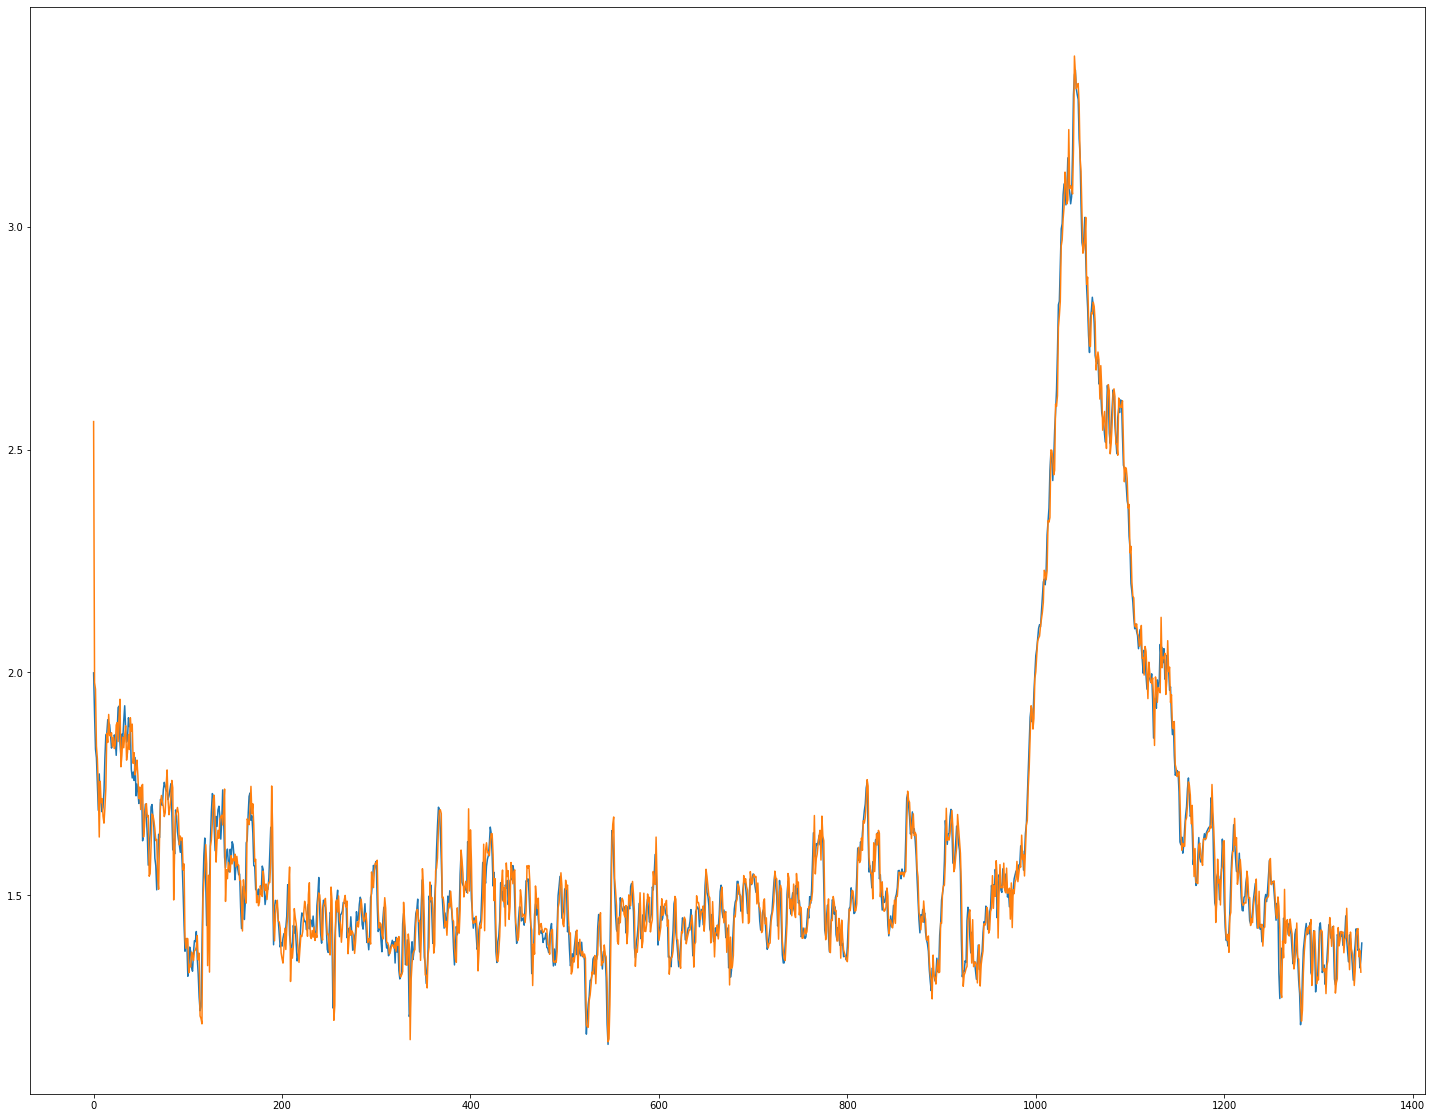

In [14]:
plt.figure(figsize=(25,20))
plt.plot(data_real)
plt.plot(predict_data)
len(data_real)

## 6. Оценка качества работы

## Заключение